### Imports

In [595]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2


### Functions

In [596]:
def display_render(image_tensor: torch.Tensor):
    im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    im = (im * 255).astype(np.uint8)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def pad_to_match_aspect(image, target_aspect_ratio):
    """
    Pads the input image (rendered image) to match the target aspect ratio.
    
    Args:
        image (torch.Tensor): Input image of shape [C, H, W].
        target_aspect_ratio (float): Target aspect ratio (width / height).

    Returns:
        torch.Tensor: Padded image with the target aspect ratio.
    """
    _, h, w = image.shape
    current_aspect_ratio = w / h

    if current_aspect_ratio < target_aspect_ratio:
        # Add padding to width
        new_width = int(h * target_aspect_ratio)
        pad = (new_width - w) // 2
        padding = (pad, pad, 0, 0)  # (left, right, top, bottom)
    else:
        # Add padding to height
        new_height = int(w / target_aspect_ratio)
        pad = (new_height - h) // 2
        padding = (0, 0, pad, pad)  # (left, right, top, bottom)
    
    return F.pad(image.unsqueeze(0), padding, mode='constant', value=0).squeeze(0)

def enforce_homogeneous_transform(matrix):
    """
    Ensures the matrix retains the properties of a homogeneous transformation.
    - The rotation part (3x3) is orthonormal.
    - The last row is [0, 0, 0, 1].
    """
    with torch.no_grad():
        # Extract the rotation part (3x3)
        rotation = matrix[:3, :3]
        
        # Re-orthogonalize using SVD
        u, _, v = torch.svd(rotation)
        rotation_orthogonal = torch.mm(u, v.t())
        
        # Update the matrix with the orthogonal rotation
        matrix[:3, :3] = rotation_orthogonal
        
        # Ensure the last row is [0, 0, 0, 1]
        matrix[:, 3] = torch.tensor([0, 0, 0, 1], device=matrix.device)
    
    return matrix

def decompose_homogeneous_matrix(matrix):
    """
    Decomposes a homogeneous transformation matrix into Euler angles and translation.
    """
    rotation_matrix = matrix[:3, :3].T.cpu().numpy()
    translation = matrix[3, :3]
    
    # Convert rotation matrix to Euler angles
    euler_angles = torch.tensor(Rotation.from_matrix(rotation_matrix).as_euler('xyz', degrees=False), device=matrix.device)
    
    return euler_angles, translation

def assemble_homogeneous_matrix(euler_angles, translation):
    """
    Constructs a homogeneous transformation matrix from Euler angles and translation.
    """
    # Convert Euler angles to rotation matrix
    rotation_matrix = torch.tensor(Rotation.from_euler('xyz', euler_angles.detach().cpu().numpy(), degrees=False).as_matrix(), device=euler_angles.device)
    
    # Create a 4x4 homogeneous transformation matrix
    matrix = torch.eye(4, device=euler_angles.device)
    matrix[:3, :3] = rotation_matrix.T
    matrix[3, :3] = translation
    
    return matrix

def optimization(camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=200):
    video = []
    losses = []
    for i in range(num_iterations):
        world_view_transform_result = assemble_homogeneous_matrix(euler_angles, translation)
        # Update the example_camera's parameters
        camera.joint_pose = joint_pose_result
        camera.world_view_transform = world_view_transform_result

        # Render the image with the current parameters
        rendered_image = torch.clamp(render(camera, gaussians, background_color)['render'], 0, 1)
        
        # padded_rendered_image = pad_to_match_aspect(rendered_image, target_aspect_ratio)

        # Compute the loss between the rendered image and the reference image
        loss = loss_fn(rendered_image, reference_image)
        losses.append(loss.item())

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the parameters
        optimizer.step()
        # world_view_transform_result = enforce_homogeneous_transform(world_view_transform_result)
        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")
            # display_render(rendered_image)
            frame = rendered_image.detach().cpu()
            # frame = frame.numpy()
            
            # ## use cv2 to print the iteration number on the image
            # frame = cv2.putText(frame, f"Iteration {i}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # frame = render(example_camera, gaussians, background_color)['render'] #3, 480, 480
            video.append(frame)
    # plot_loss(losses)
    return video, joint_pose_result, assemble_homogeneous_matrix(euler_angles.detach(), translation.detach()), euler_angles, translation

def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iteration')
    plt.show()

# Function to count the number of files in a folder
def count_files(path):
    return len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])


def make_video(video, filename, fps=30):
    video = torch.stack(video)
    video = torch.clamp(video, 0, 1)
    video = video.cpu().detach().numpy()
    video = np.transpose(video, (0, 2, 3, 1))    
    video = (video * 255).astype(np.uint8)

    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")


### Initialization

In [597]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/p_short_exp_2', bg_color=[0, 0, 0])

# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/p_short_exp_2
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path


In [598]:
## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = 0.0
cam.elevation = -20
cam.lookat = (0,0,-0.4)
extrinsic = compute_camera_extrinsic_matrix(cam)
w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)
w2v_tensor = torch.tensor(getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)).transpose(0, 1).to(example_camera.data_device)
print(w2v)

## rotate the view
theta = -np.pi / 2  # 90 degrees in radians
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

R = w2v[:3, :3]
t = w2v[:3, 3]

# Apply translation
t[1] = -0.5

# Apply the rotation
R_rotated = R_z @ R  # Rotate the original rotation matrix
t_rotated = R_z @ t  # Rotate the translation vector

# Combine back into a transformation matrix
T_rotated = np.eye(4)
T_rotated[:3, :3] = R_rotated
T_rotated[:3, 3] = t_rotated

T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

example_camera.world_view_transform = T_rotated_torch
print(example_camera.world_view_transform)


[[-0.         -1.         -0.         -0.        ]
 [-0.34202015 -0.         -0.9396926  -0.37587705]
 [ 0.9396926   0.         -0.34202015 -0.03680806]
 [ 0.          0.          0.          1.        ]]
tensor([[-3.4202e-01, -2.0943e-17,  9.3969e-01,  0.0000e+00],
        [-6.1232e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.3969e-01, -5.7540e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.0616e-17, -3.6808e-02,  1.0000e+00]])


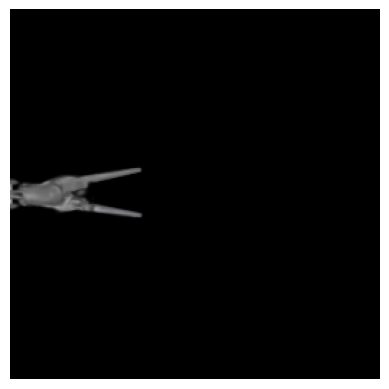

w2v: tensor([[-3.4202e-01, -2.0943e-17,  9.3969e-01,  0.0000e+00],
        [-6.1232e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.3969e-01, -5.7540e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01, -3.0616e-17, -3.6808e-02,  1.0000e+00]],
       requires_grad=True)
Sum of joint gradients: tensor(345.9553)
Sum of camera gradients: tensor(34513.9180)


In [599]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())    
home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
result = render(example_camera, gaussians, background_color)

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
frame = mask  # Use the mask directly without clamping or thresholding

# Display the mask (optional, normalized for visualization)
display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)
frame.sum().backward()
print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

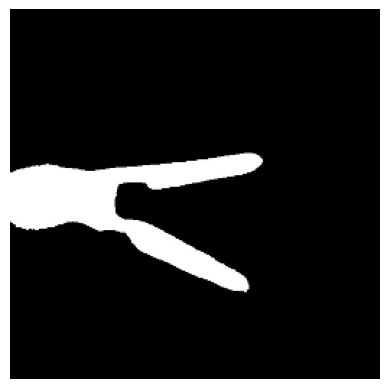

Reference image shape: torch.Size([3, 256, 256])
1.0


In [600]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)

plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
print(target_aspect_ratio)


### Optimization

In [601]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().requires_grad_(True)  # Initial camera transform

# Define different learning rates
joint_pose_lr = 2e-4
world_transform_lr = 1e-4

# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])

# Initialize Euler angles and translation as optimization variables
euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": euler_angles, "lr": world_transform_lr},
    {"params": translation, "lr": world_transform_lr}
])

num_iterations = 500

loss_fn = torch.nn.MSELoss()
video = []


In [602]:

# Optimization loop
video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=num_iterations)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


Iteration 0: Loss = 0.0778912603855133
Iteration 10: Loss = 0.07746240496635437
Iteration 20: Loss = 0.07645495980978012
Iteration 30: Loss = 0.07609084248542786
Iteration 40: Loss = 0.0756157636642456
Iteration 50: Loss = 0.07512374967336655
Iteration 60: Loss = 0.07458215951919556
Iteration 70: Loss = 0.07402971386909485
Iteration 80: Loss = 0.07351553440093994
Iteration 90: Loss = 0.07299745082855225
Iteration 100: Loss = 0.07248727232217789
Iteration 110: Loss = 0.07201679050922394
Iteration 120: Loss = 0.07157672941684723
Iteration 130: Loss = 0.07122054696083069
Iteration 140: Loss = 0.07092525064945221
Iteration 150: Loss = 0.0706329345703125
Iteration 160: Loss = 0.07036451995372772
Iteration 170: Loss = 0.07010442018508911
Iteration 180: Loss = 0.06983776390552521
Iteration 190: Loss = 0.06955239921808243
Iteration 200: Loss = 0.06925018876791
Iteration 210: Loss = 0.06895008683204651
Iteration 220: Loss = 0.06859968602657318
Iteration 230: Loss = 0.06822393834590912
Iteration

MoviePy - Building file pose_est_init.gif with imageio.


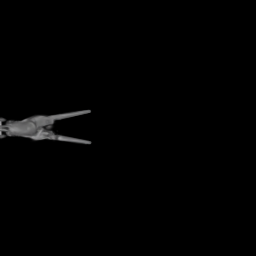

In [603]:
## ------ Save the video ------ ##
make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


(-0.5, 255.5, 255.5, -0.5)

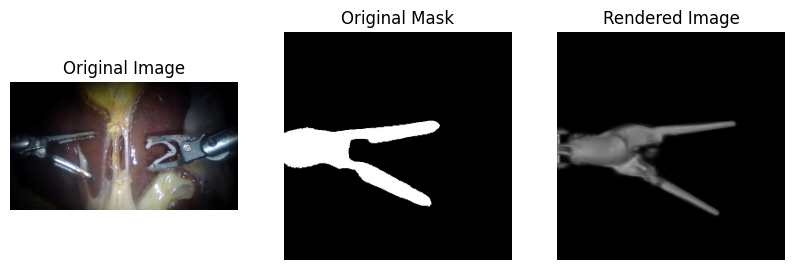

In [604]:
## ------ Compare the final rendered image and the reference image------ ##

final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)

# display_render(final_render)
padded_rendered_image = pad_to_match_aspect(final_render, target_aspect_ratio)
## subplot to show the original image and the rendered image
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original Image")
ax.imshow(original_image)
ax.axis('off')

ax = plt.subplot(1, 3, 2)
ax.set_title("Original Mask")
ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
ax.axis('off')

subplot = plt.subplot(1, 3, 3)
subplot.set_title("Rendered Image")
subplot.imshow(final_render.detach().permute(1, 2, 0).cpu().numpy())
subplot.axis('off')


Number of images: 116
MoviePy - Building file mask.gif with imageio.


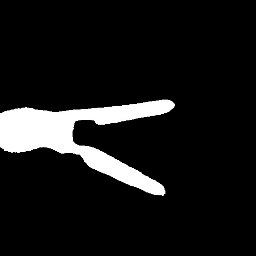

In [605]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = count_files(image_folder)
for i in range(int(image_num / 2)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    img = np.array(img)[:540, :540]
    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

make_video(imgs, filename="mask")

IPImage(filename="mask.gif")

In [606]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []
# Optimization loop
num_iterations = 3
# Define different learning rates
joint_pose_lr = 1e-3
world_transform_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": euler_angles, "lr": world_transform_lr},
    {"params": translation, "lr": world_transform_lr}
])
for img in imgs:
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result)
    world_view_transform_results.append(world_view_transform_result)
    euler_results.append(euler_result)
    trans_results.append(trans_result)
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


Iteration 0: Loss = 0.04443342611193657
Iteration 0: Loss = 0.04441606625914574
Iteration 0: Loss = 0.04466156288981438
Iteration 0: Loss = 0.0444454662501812
Iteration 0: Loss = 0.04400288313627243
Iteration 0: Loss = 0.043895475566387177
Iteration 0: Loss = 0.043595343828201294
Iteration 0: Loss = 0.043617140501737595
Iteration 0: Loss = 0.04358204826712608
Iteration 0: Loss = 0.04475332424044609
Iteration 0: Loss = 0.04498432204127312
Iteration 0: Loss = 0.0452222004532814
Iteration 0: Loss = 0.04465975612401962
Iteration 0: Loss = 0.045712750405073166
Iteration 0: Loss = 0.0581948384642601
Iteration 0: Loss = 0.06343179941177368
Iteration 0: Loss = 0.06488099694252014
Iteration 0: Loss = 0.06573827564716339
Iteration 0: Loss = 0.06576428562402725
Iteration 0: Loss = 0.0660717636346817
Iteration 0: Loss = 0.06501858681440353
Iteration 0: Loss = 0.06432300060987473
Iteration 0: Loss = 0.05797126889228821
Iteration 0: Loss = 0.060264360159635544
Iteration 0: Loss = 0.05871327966451645

MoviePy - Building file tracking_sequence.gif with imageio.


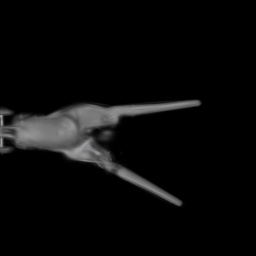

In [607]:
## ------ Save the video ------ ##
make_video(videos, "tracking_sequence")
IPImage(filename="tracking_sequence.gif")


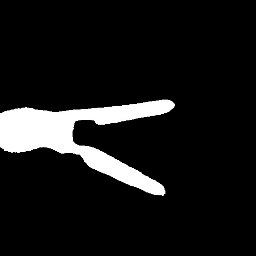

In [608]:
IPImage(filename="mask.gif")


In [609]:
trans_results

[Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tensor([-0.4656, -0.0094, -0.1212], requires_grad=True),
 Parameter containing:
 tens